# Conditional variational autoencoders with learnable conditional embeddings

Code for my medium article.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils
import torch.distributions
import torchvision
import lightning.pytorch as pl

import numpy as np

# If you don't have access to a GPU use device='cpu'
device = 'cuda'

In [3]:
# Load data
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('/scratch/trose/mnist',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [6]:

class CondVariationalEncoder(nn.Module):
    
    # The encoder gets the label as an one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalEncoder, self).__init__()
        # The dimensions of the one-hot encoding are added concatenated to the input
        self.linear1 = nn.Linear(784 + n_classes, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        # Get sampling working on GPU
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    # The labels are provided as variable `y`
    def forward(self, x, y):
        x = torch.flatten(x, start_dim=1)
        x = x.view(-1, 1*28*28)
        # Here the label one-hot encoding is concatenated to the image
        x = functional.relu(self.linear1(torch.cat((x,y),dim=1)))
        # Mean
        mu =  self.linear2(x)
        # Variance
        sigma = torch.exp(self.linear3(x))
        
        # Sample latent vector for images
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
    
class CondVariationalDecoder(nn.Module):
    
    # The decoder gets the label as a one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalDecoder, self).__init__()
        # The dimensions of the one-hot encoding are concatenated to the input
        self.linear1 = nn.Linear(latent_dims + n_classes, 512)
        self.linear2 = nn.Linear(512, 784)
        
    # Labels are provided as variable `y`
    def forward(self, z, y):
        # Here the label one-hot encoding is concatenated to the image
        z = functional.relu(self.linear1(torch.cat((z,y),dim=1)))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [7]:
class CondVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalAutoencoder, self).__init__()
        self.encoder = CondVariationalEncoder(latent_dims, n_classes)
        self.decoder = CondVariationalDecoder(latent_dims, n_classes)
    
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z, y)

In [8]:
# First, we define Lightning module for the CVAE model
class CVAEModel(pl.LightningModule):
    # In the constructor we just use the previously defined CVAE model and number of classes
    def __init__(self, latent_dims, n_classes):
        super().__init__()
        self.cvae = CondVariationalAutoencoder(latent_dims, n_classes)
        self.n_classes = n_classes

    # Lightning requires a training step function in which the forward step is executed and loss calculated
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_oh = torch.nn.functional.one_hot(y, num_classes=self.n_classes)
        
        
        x_hat = self.cvae(x, y_oh)
        loss = loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl
        
        # For to see the loss during training, we add the current loss to the logger
        self.log('Training loss', loss, on_step=False, on_epoch=True, logger=False, prog_bar=True)
        
        return loss
    
    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [9]:
# Training of the model
latent_dims=2
model = CVAEModel(latent_dims=latent_dims, n_classes=10)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Missing logger folder: /home/trose/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                       | Params
----------------------------------------------------
0 | cvae | CondVariationalAutoencoder | 817 K 
--------------------

Epoch 19: 100%|██████████| 469/469 [00:06<00:00, 76.72it/s, v_num=0, Training loss=4.26e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:06<00:00, 76.27it/s, v_num=0, Training loss=4.26e+3]


In [17]:
import matplotlib.pyplot as plt

def plot_reconstructed(autoencoder, r0=(-3, 3), r1=(-3, 3), n=8, number=2, device='cuda'):
    # Define plot array:
    fig, axs = plt.subplots(n, n)

    # Loop over a grid in the latent space
    for i, a in enumerate(np.linspace(*r1, n)):
        for j, b in enumerate(np.linspace(*r0, n)):
            
            z = torch.Tensor([[a, b]]).to(device)
            # One-hot encoding of the integer
            y = functional.one_hot(torch.tensor([number]), 
                                   num_classes=10).to(device)
            # Forwarding the data through the decoder
            x_hat = autoencoder.decoder(z, y)
            
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            axs[i, j].imshow(x_hat)
            axs[i, j].axis('off')
    plt.show()

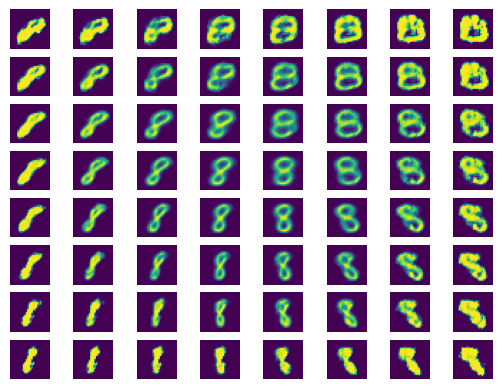

In [18]:
model = model.to(device)
plot_reconstructed(model.cvae, number=8, device=device)

In [19]:
class eCVAEModel(pl.LightningModule):
    # Here we need to define the number of classes and embedding dimensions
    def __init__(self, latent_dims, n_classes, embedding_dims):
        super().__init__()
        # We can use the CVAE model from the previous notebook, but instead of using the number of classes for a one-hot encoding,
        # we use the embedding dimensions
        self.cvae = CondVariationalAutoencoder(latent_dims, embedding_dims)
        self.n_classes = n_classes
        self.embedding_dims = embedding_dims
        self.embed_cond = nn.Embedding(num_embeddings=n_classes, embedding_dim=embedding_dims, max_norm=True)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Instead of a one-hot encoding, the embeddings are used as conditional variables
        x_hat = self.cvae(x, self.embed_cond(y))
        loss = loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl
        
        self.log('Training loss', loss, on_step=False, on_epoch=True, logger=False, prog_bar=True)
        
        return loss
    
    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)


In [20]:
emodel = eCVAEModel(latent_dims=latent_dims, n_classes=10, embedding_dims=5)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(emodel, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K 
1 | embed_cond | Embedding                  | 50    
----------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performanc

Epoch 19: 100%|██████████| 469/469 [00:06<00:00, 69.52it/s, v_num=1, Training loss=4.19e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:06<00:00, 69.15it/s, v_num=1, Training loss=4.19e+3]


In [21]:
def plot_reconstructed_ecvae(model, r0=(-3, 3), r1=(-3, 3), n=8, number=2, device='cuda'):
    # Define plot array:
    fig, axs = plt.subplots(n, n)

    # Loop over a grid in the latent space
    for i, a in enumerate(np.linspace(*r1, n)):
        for j, b in enumerate(np.linspace(*r0, n)):
            
            z = torch.Tensor([[a, b]]).to(device)
            # One-hot encoding of the integer
            y = model.embed_cond(torch.tensor([number]).to(device))
            # Forwarding the data through the decoder
            x_hat = model.cvae.decoder(z, y)
            
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            axs[i, j].imshow(x_hat)
            axs[i, j].axis('off')
    plt.show()

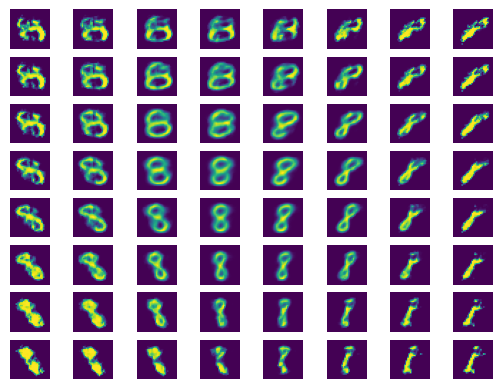

In [23]:
emodel = emodel.to(device)
plot_reconstructed_ecvae(emodel, number=8, device=device)

In [24]:
# Creating dataloaders excluding 8 & 9 digits
# Code adapted from: https://stackoverflow.com/questions/75034387/remove-digit-from-mnist-pytorch
dstrain = torchvision.datasets.MNIST('/scratch/trose/mnist',
                                transform=torchvision.transforms.ToTensor(),
                                download=True)
idxn9 = dstrain.targets!=9
idxn8 = dstrain.targets!=8
idx = idxn9 & idxn8

dstrain.targets = dstrain.targets[idx]
dstrain.data = dstrain.data[idx]

# Data containing only 8 & 9 digits
ds89 = torchvision.datasets.MNIST('/scratch/trose/mnist',
                                transform=torchvision.transforms.ToTensor(),
                                download=True)
idx9 = ds89.targets==9
idx8 = ds89.targets==8
idx89 = idx9 | idx8
ds89.targets = ds89.targets[idx89]
ds89.data = ds89.data[idx89]

datatrain = torch.utils.data.DataLoader(dstrain, batch_size=128, shuffle=True)
data89 = torch.utils.data.DataLoader(ds89, batch_size=128, shuffle=True)

In [25]:
emodel89 = eCVAEModel(latent_dims=latent_dims, n_classes=10, embedding_dims=5)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(emodel89, datatrain)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K 
1 | embed_cond | Embedding                  | 50    
----------------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performanc

Epoch 19: 100%|██████████| 377/377 [00:05<00:00, 72.07it/s, v_num=2, Training loss=4.53e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 377/377 [00:05<00:00, 71.59it/s, v_num=2, Training loss=4.53e+3]


In [28]:
# Freeze model parameters
for name, param in emodel89.named_parameters():
    if name == 'embed_cond.weight':
        param.requires_grad = True
    else:
        param.requires_grad = False

# Training just on 8 & 9 digits on frozen weights
# The model is using the previously created embedding vectors in the model that were not updated for 8 & 9 in the previous training.
trainer89 = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer89.fit(emodel89, data89)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K 
1 | embed_cond | Embedding                  | 50    
----------------------------------------------------------
50        Trainable params
812 K     Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/93 [00:00<?, ?it/s] 

Epoch 19: 100%|██████████| 93/93 [00:01<00:00, 74.33it/s, v_num=5, Training loss=5.62e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 93/93 [00:01<00:00, 73.28it/s, v_num=5, Training loss=5.62e+3]


Epoch 0:   0%|          | 0/93 [01:07<?, ?it/s]


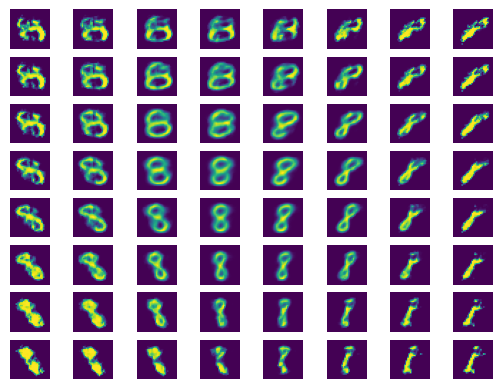

In [29]:
emodel89 = emodel.to(device)
plot_reconstructed_ecvae(emodel89, number=8, device=device)